#  Чётенькое такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Библиотеки

In [68]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

Убрираем длинные циферки.

In [70]:
pd.set_option('display.float_format', '{:,.3f}'.format)

Отключаем лишние предупреждения.

In [71]:
import warnings
warnings.filterwarnings('ignore')

### Функции

#### column_values

In [72]:
def column_values(data_frame):
    '''
    Функция для визуального поиска артефактов и выбросов в значениях DataFrame
    '''
    for column in data_frame.columns:
        print('\nЗначения столбца', column,':')
        print(data_frame[column].sort_values().unique())

#### cv_sample

In [73]:
def cv_sample(regressor,
              data_frame,
              target_column,
              n_splits,
              max_train_size):
    '''
    Создание CV выборки для временных рядов через TimeSeriesSplit
    '''
    tss = TimeSeriesSplit(n_splits = n_splits,
                          max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tss.split(data_frame):
        train = data_frame.iloc[train_index]
        test = data_frame.iloc[test_index]
        train_features = train.drop(target_column,
                                    axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column,
                                  axis=1)
        test_target = test[target_column]
        regressor.fit(train_features,
                      train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits

#### df_info

In [74]:
def df_info(data_frame):
    '''
    Функция выводящая первичную информацию о DataFrame
    '''
    print('\nИнфо:')
    print(data_frame.info())                                            # сколько значений и в каком формате
    print('\nПропусков:')
    print(data_frame.isna().mean().sort_values(ascending = False) * 100)  # подсчёт пропусков в процентах
    print('\nОписание:')
    display(data_frame.describe())                                      # вдруг чего "на глазок" проявится 
    print('\nДубликатов =', data_frame.duplicated().sum())              # проверим дубликаты

#### make_features

In [75]:
def make_features(data_frame,
                  column,
                  max_lag,
                  rolling_mean_size):
    '''
    Cоздание признаков для обучения модели
    '''
    data_frame['day'] = data_frame.index.day
    data_frame['dayofweek'] = data_frame.index.dayofweek
    data_frame['month'] = data_frame.index.month
    for lag in range(1, max_lag + 1):
        data_frame['lag_{}'.format(lag)] = data_frame[column].shift(lag)
    data_frame['rolling_mean'] = data_frame[column].shift().rolling(rolling_mean_size).mean()

### Таблица

Читаем файл с данными и сохраняем в df.

In [76]:
try:
    df = pd.read_csv('/datasets/taxi.csv',
                     index_col=[0],
                     parse_dates=[0])
except Exception:
    ! gdown --id 16El-AewAQTZROQqk1SymBwsQ7QJibN6P
    df = pd.read_csv('/content/taxi.csv',
                     index_col=[0],
                     parse_dates=[0])

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16El-AewAQTZROQqk1SymBwsQ7QJibN6P
To: /content/taxi.csv
100% 600k/600k [00:00<00:00, 75.9MB/s]


Смотрим табличку.

In [77]:
display(df.columns)
print()
display(df.head())

Index(['num_orders'], dtype='object')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим заполненость таблицы.

In [78]:
df_info(df)


Инфо:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

Пропусков:
num_orders   0.000
dtype: float64

Описание:


,num_orders
count,"26,496.000"
mean,14.070
std,9.211
min,0.000
25%,8.000
50%,13.000
75%,19.000
max,119.000



Дубликатов = 26415


### Вывод

    - Вроде бы все "ровно", но 26415 дубликатов из 26496 значений...
      Интересно.

## Анализ

Отлавливаем артефакты в данных.

In [79]:
column_values(df)


Значения столбца num_orders :
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  60  61  62  64  65  66  67  68  71  76  78  80  81
  82  87  90  91  94  95  98  99 119]


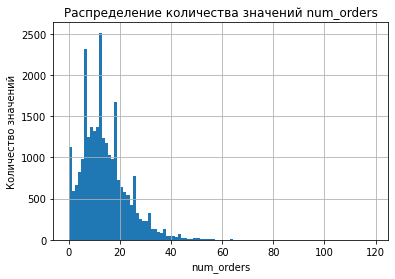

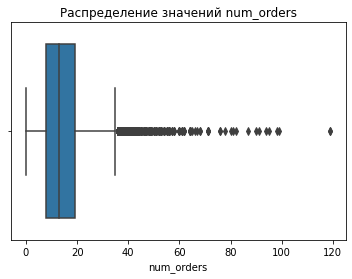

In [80]:
display(df['num_orders'].hist(bins = 100))
plt.title("Распределение количества значений num_orders")
plt.xlabel("num_orders")
plt.ylabel("Количество значений")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'num_orders',
                         orient = 'h'))
plt.title("Распределение значений num_orders")
plt.xlabel("num_orders")
plt.show()

За какой период смотрим?

In [81]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Как выглядят наши данные?

Text(0.5, 1.0, 'Распределение по неделям')

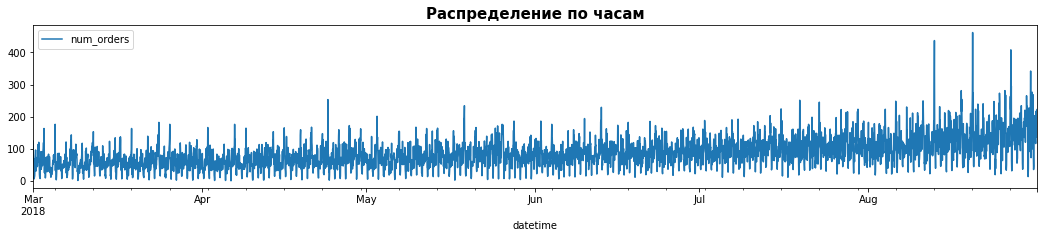

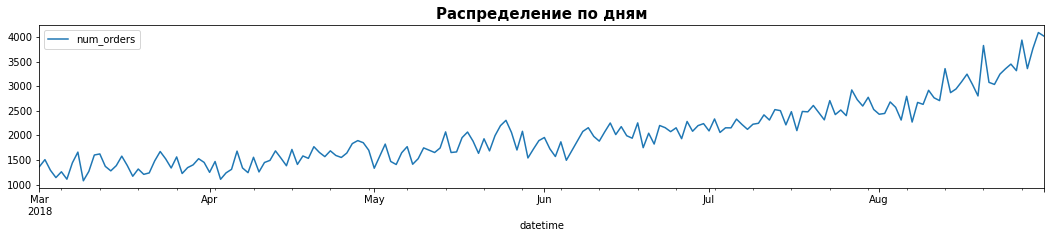

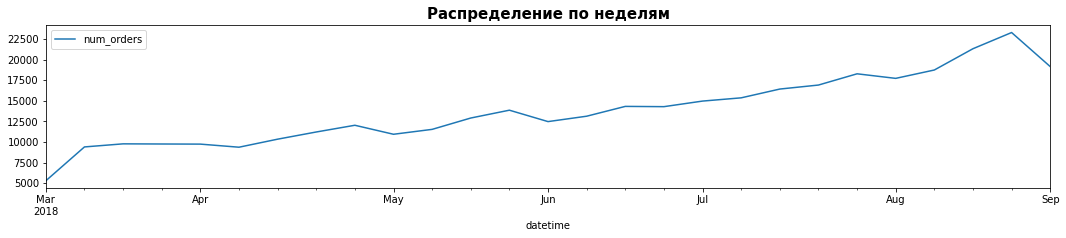

In [82]:
figsize = (18, 3)

df_h = df.resample('1H').sum()
df_h.plot(figsize = figsize)
plt.title('Распределение по часам',
          fontsize = 15,
          fontweight = 'bold')

df_d = df.resample('1D').sum()
df_d.plot(figsize = figsize)
plt.title('Распределение по дням',
          fontsize = 15,
          fontweight = 'bold')

df_w = df.resample('1W').sum()
df_w.plot(figsize = figsize)
plt.title('Распределение по неделям',
          fontsize = 15,
          fontweight = 'bold')


Сделаем декомпозицию, посмотрим тренды и сезонность заказа такси.

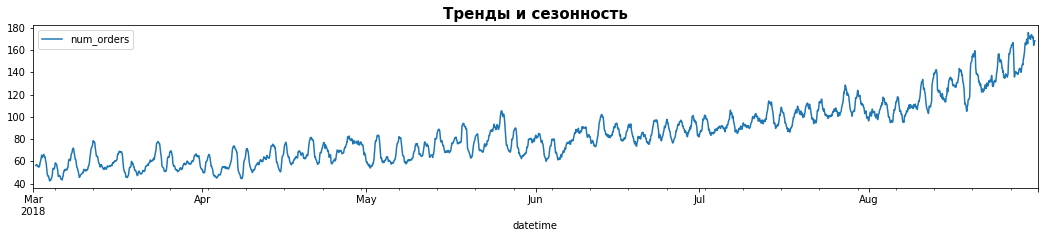

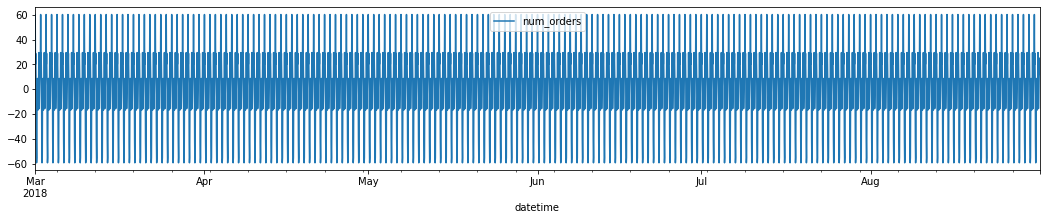

In [83]:
decomposed_df = seasonal_decompose(df_h)
decomposed_df.trend.plot(figsize = figsize)
plt.title('Тренды и сезонность',
          fontsize = 15,
          fontweight = 'bold')
decomposed_df.seasonal.plot(figsize = figsize)

Укрупним до месяца.

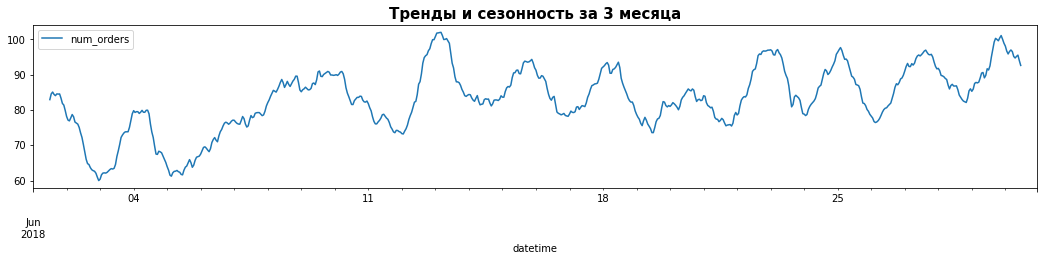

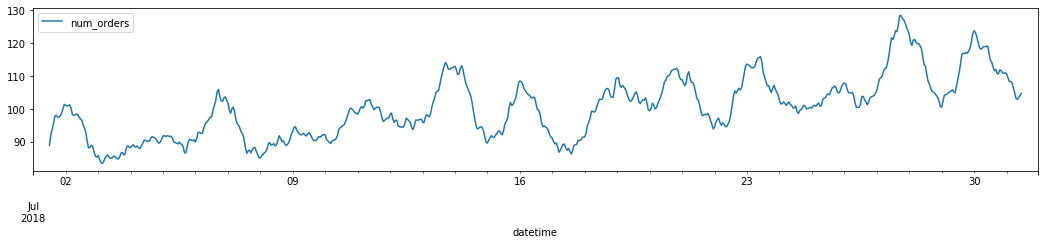

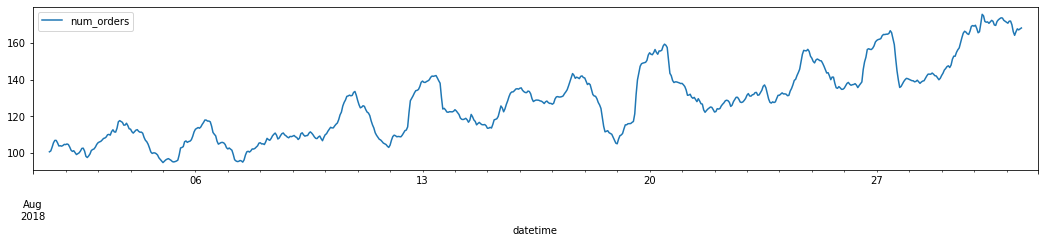

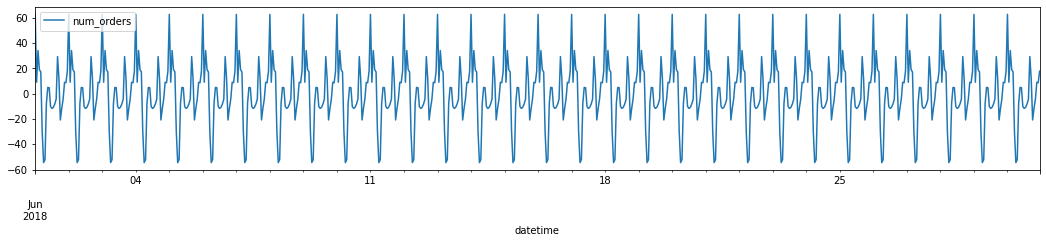

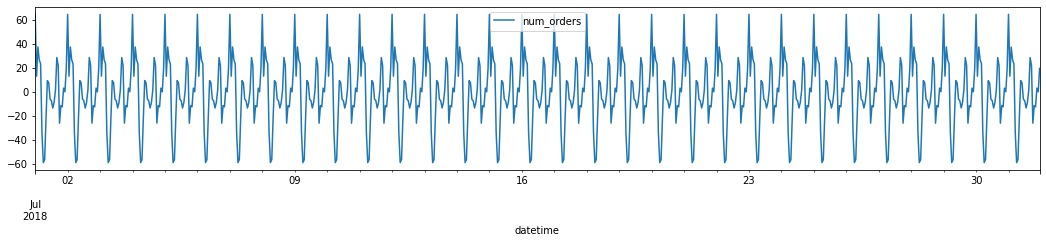

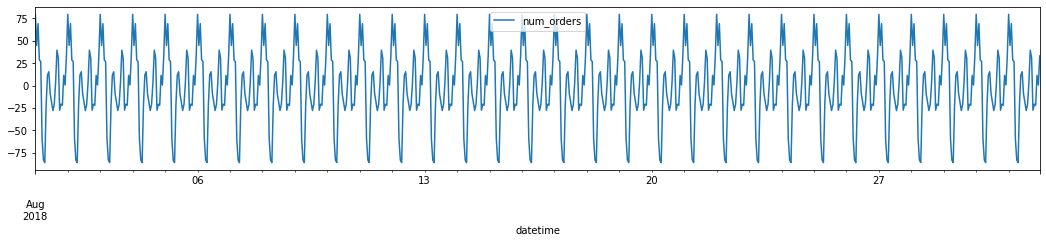

In [84]:
decomposed_df_h_jun = seasonal_decompose(df_h['2018-06-1':'2018-06-30'])
decomposed_df_h_jul = seasonal_decompose(df_h['2018-07-1':'2018-07-31'])
decomposed_df_h_aug = seasonal_decompose(df_h['2018-08-1':'2018-08-31'])

decomposed_df_h_jun.trend.plot(figsize = figsize)
plt.title('Тренды и сезонность за 3 месяца',
          fontsize = 15,
          fontweight = 'bold')
decomposed_df_h_jul.trend.plot(figsize = figsize)
decomposed_df_h_aug.trend.plot(figsize = figsize)

decomposed_df_h_jun.seasonal.plot(figsize = figsize)
decomposed_df_h_jul.seasonal.plot(figsize = figsize)
decomposed_df_h_aug.seasonal.plot(figsize = figsize)

Укрупним до недель.

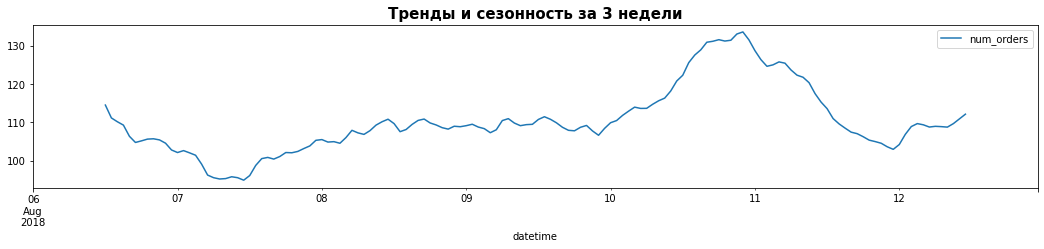

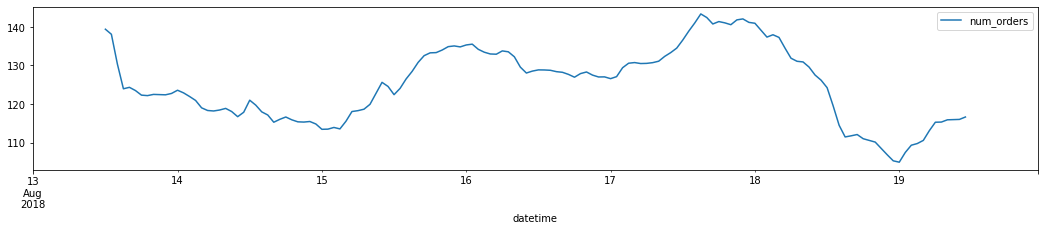

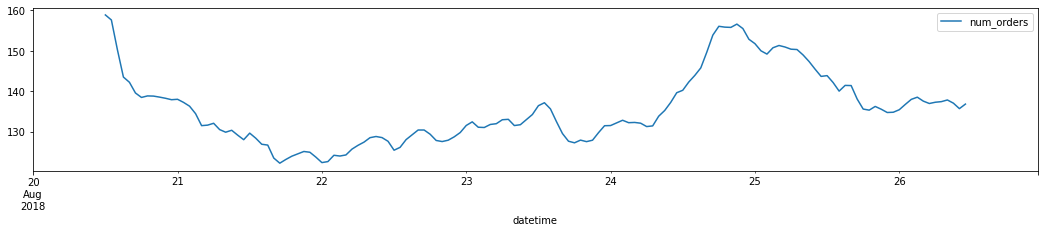

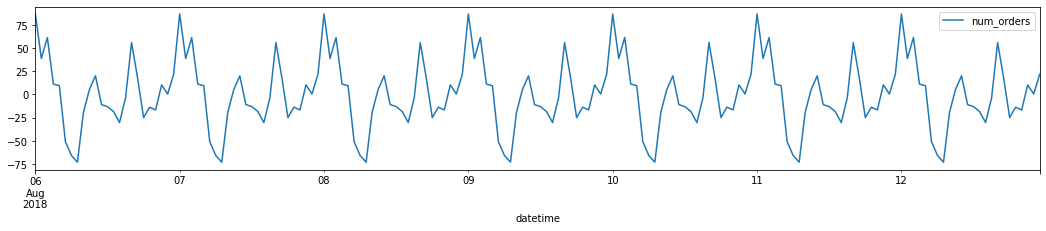

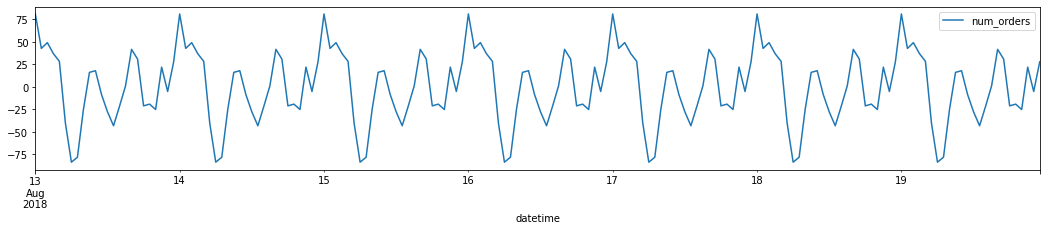

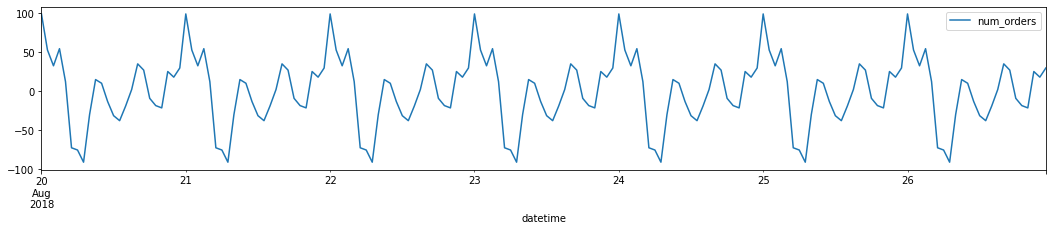

In [85]:
decomposed_df_h_1 = seasonal_decompose(df_h['2018-08-6':'2018-08-12'])
decomposed_df_h_2 = seasonal_decompose(df_h['2018-08-13':'2018-08-19'])
decomposed_df_h_3 = seasonal_decompose(df_h['2018-08-20':'2018-08-26'])

decomposed_df_h_1.trend.plot(figsize = figsize)
plt.title('Тренды и сезонность за 3 недели',
          fontsize = 15,
          fontweight = 'bold')
decomposed_df_h_2.trend.plot(figsize = figsize)
decomposed_df_h_3.trend.plot(figsize = figsize)

decomposed_df_h_1.seasonal.plot(figsize = figsize)
decomposed_df_h_2.seasonal.plot(figsize = figsize)
decomposed_df_h_3.seasonal.plot(figsize = figsize)

Укрупним до часов.

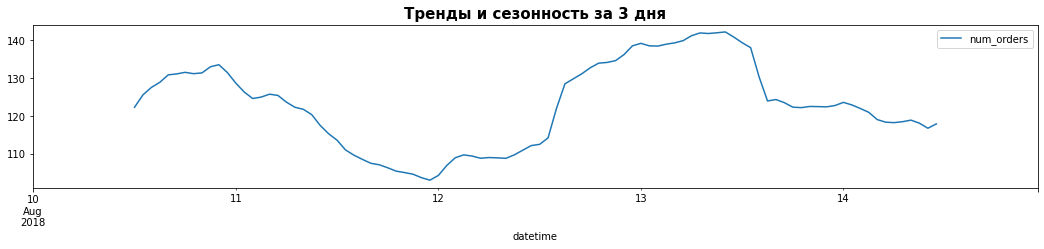

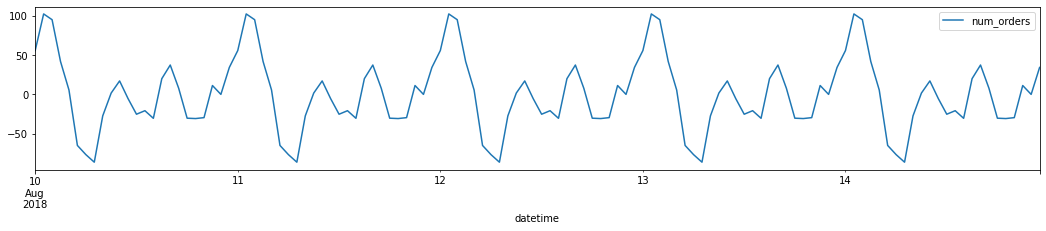

In [86]:
decomposed_df_h = seasonal_decompose(df_h['2018-08-10':'2018-08-14'])
decomposed_df_h.trend.plot(figsize = figsize)
plt.title('Тренды и сезонность за 3 дня',
          fontsize = 15,
          fontweight = 'bold')
decomposed_df_h.seasonal.plot(figsize = figsize)

### Вывод

    - В общем количество заказов растет.
    - Максимум заказов приходится на
        - суббота
        - ночь
    - Минимум заказов приходится на
        - вторник и среда
        - утро

## Обучение

### Подготовка данных

Посмотрим, какие признаки нам понадобится:

    - Видна ежедневная сезонность - понадобится признак day.
    - Есть закономерности по дням недели - добавим признак dayofweek.
    - Помесячные данные отличаются, но довольно похожи - добавим признак month.

In [87]:
max_lag = 24
rolling_mean_size = 5
random_state = 1980

Делаем тестовую выборку размером 10% от исходных данных.

In [88]:
make_features(df_h,
              'num_orders',
              max_lag,
              rolling_mean_size)

train, test = train_test_split(df_h,
                               shuffle = False,
                               test_size = 0.1,
                               random_state = random_state)
train = train.dropna()
features_train = train.drop('num_orders',
                            axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders',
                          axis=1)
target_test = test['num_orders']

print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

Размер обучающей выборки: 3950 объектов, 28 признаков
Размер тестовой выборки: 442 объектов, 28 признаков


Посмотрим корреляцию признаков.

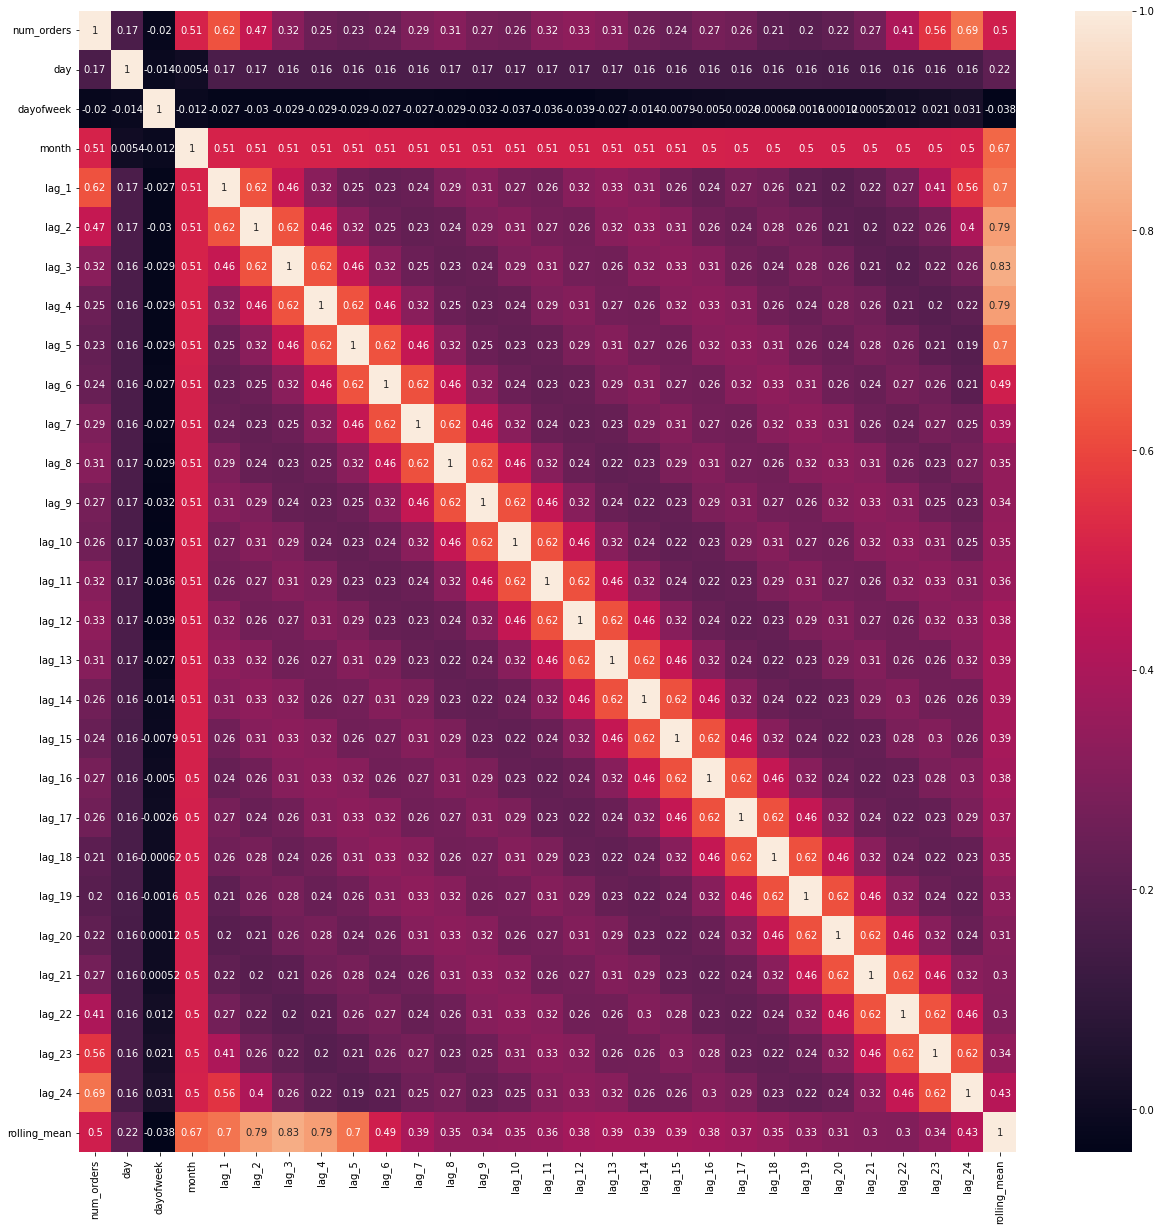

In [89]:
figure = plt.figure(figsize = (21, 21))
sns.heatmap(df_h.corr(method = 'pearson'),
            annot = True)

### Общие переменные

In [95]:
data_frame  = train
target_column = 'num_orders'
n_splits = 3
max_train_size = (train.shape[0] * 4 //5)

### LinearRegression

In [106]:
%%time
regressor_lr = LinearRegression()
hyperparams = {'normalize':[True, False]}
tss = TimeSeriesSplit(n_splits = n_splits,
                      max_train_size = max_train_size)
grid_lr = GridSearchCV(regressor_lr,
                       hyperparams,
                       scoring='neg_root_mean_squared_error',
                       cv=tss ,
                       n_jobs = -1)
grid_lr.fit(features_train,
            target_train)
best_params_lr = grid_lr.best_params_
print('\nЛучший набор параметров LinearRegression:\n', best_params_lr, '\n')


Лучший набор параметров LinearRegression:
 {'normalize': True} 

CPU times: user 66.8 ms, sys: 11.9 ms, total: 78.6 ms
Wall time: 181 ms


In [103]:
rmse_lr = cv_sample(regressor_lr,
                    data_frame, 
                    target_column, 
                    n_splits, 
                    max_train_size)
print('\nRMSE для LinearRegression =', rmse_lr, '\n')     


RMSE для LinearRegression = 27.53088981465821 



### DecisionTreeRegressor

In [107]:
%%time
regressor_dtr = DecisionTreeRegressor()
#max_depth = [depth for depth in range(1, 50)]
max_depth = [depth for depth in range(3, 5)]
hyperparams = [{#'criterion':['mse', 'squared_error', 'friedman_mse'],
                'criterion':['mse'],
                'max_depth':max_depth, 
                'random_state':[random_state]}]
grid_dtr = GridSearchCV(regressor_dtr,
                        hyperparams,
                        scoring='neg_root_mean_squared_error')
grid_dtr.fit(features_train,
             target_train)
best_params_dtr = grid_dtr.best_params_
print('\nЛучший набор параметров DecisionTreeRegressor:\n', best_params_dtr, '\n')


Лучший набор параметров DecisionTreeRegressor:
 {'criterion': 'mse', 'max_depth': 4, 'random_state': 1980} 

CPU times: user 415 ms, sys: 3.01 ms, total: 418 ms
Wall time: 452 ms


In [100]:
%%time
regressor_dtr.set_params(**best_params_dtr)
rmse_dtr = cv_sample(regressor_dtr,
                     data_frame, 
                     target_column, 
                     n_splits, 
                     max_train_size)
print('\nRMSE для DecisionTreeRegressor =', rmse_dtr, '\n')

RMSE для DecisionTreeRegressor = 31.50623451409257 

CPU times: user 67.7 ms, sys: 2.78 ms, total: 70.5 ms
Wall time: 73.5 ms


### CatBoostRegressor

In [108]:
%%time
regressor_cbr = CatBoostRegressor() 
hyperparams = [{#'learning_rate':[x/100 for x in range(1, 200)],
                'learning_rate':[x/100 for x in range(3, 5)],
                'verbose':[False],
                'random_state':[random_state]}]
grid_cbr = GridSearchCV(regressor_cbr,
                        hyperparams,
                        scoring='neg_root_mean_squared_error')
grid_cbr.fit(features_train,
             target_train)
best_params_cbr = grid_cbr.best_params_
print('Лучший набор параметров CatBoostRegressor:\n', best_params_cbr, '\n')

Лучший набор параметров CatBoostRegressor:
 {'learning_rate': 0.04, 'random_state': 1980, 'verbose': False} 

CPU times: user 2min 20s, sys: 14.1 s, total: 2min 34s
Wall time: 1min 47s


In [109]:
%%time
regressor_cbr.set_params(**best_params_cbr)
rmse_cbr = cv_sample(regressor_cbr,
                     data_frame, 
                     target_column, 
                     n_splits, 
                     max_train_size)
print('\nRMSE для CatBoostRegressor =', rmse_cbr, '\n')


RMSE для CatBoostRegressor = 26.240442152104084 

CPU times: user 29.1 s, sys: 2.02 s, total: 31.2 s
Wall time: 18.3 s


### LGBMRegressor

In [110]:
%%time
regressor_lgbmr = LGBMRegressor() 
hyperparams = [{#'learning_rate':[x/100 for x in range(1, 200)],
                'learning_rate':[x/100 for x in range(4, 6)],
                #'n_estimators':[50, 150, 300],
                'n_estimators':[300],
                #'num_leaves':[6, 12, 24],
                'num_leaves':[12],
                'boosting_type':['gbdt'],
                'random_state':[random_state]}]
grid_lgbmr = GridSearchCV(regressor_lgbmr,
                          hyperparams,
                          scoring='neg_root_mean_squared_error')
grid_lgbmr.fit(features_train,
               target_train)
best_params_lgbmr = grid_lgbmr.best_params_
print('\nЛучший набор параметров LGBMRegressor:\n', best_params_lgbmr, '\n')


Лучший набор параметров LGBMRegressor:
 {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 300, 'num_leaves': 12, 'random_state': 1980} 

CPU times: user 12 s, sys: 159 ms, total: 12.2 s
Wall time: 7.48 s


In [111]:
%%time
regressor_lgbmr.set_params(**best_params_lgbmr)
rmse_lgbmr = cv_sample(regressor_lgbmr,
                       data_frame, 
                       target_column, 
                       n_splits, 
                       max_train_size)
print('\nRMSE для LGBMRegressor =', rmse_lgbmr, '\n')


RMSE для LGBMRegressor = 26.911045220329708 

CPU times: user 2.02 s, sys: 51 ms, total: 2.07 s
Wall time: 1.08 s


## Тестирование

### LinearRegression

In [112]:
%%time
regressor_lr.fit(features_train,
                 target_train)
predict_lr = regressor_lr.predict(features_test)
rmse_lr_test = mean_squared_error(target_test, predict_lr) ** 0.5
print('\nRMSE для LinearRegression =', rmse_lr_test, '\n')


RMSE для LinearRegression = 45.529337080209366 

CPU times: user 17.2 ms, sys: 10.1 ms, total: 27.3 ms
Wall time: 21 ms


Посмотрим предсказания с реальными данными.

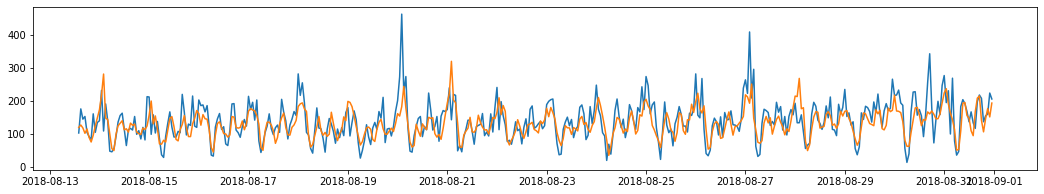

In [113]:
plt.figure(figsize = figsize)
plt.plot(target_test.index,
         target_test,
         target_test.index,
         predict_lr)

### DecisionTreeRegressor

In [114]:
%%time
regressor_dtr.fit(features_train,
                  target_train)
predict_dtr = regressor_dtr.predict(features_test)
rmse_dtr_test = mean_squared_error(target_test, predict_dtr) ** 0.5
print('\nRMSE для DecisionTreeRegressor =', rmse_dtr_test, '\n')


RMSE для DecisionTreeRegressor = 65.25751287342584 

CPU times: user 113 ms, sys: 931 µs, total: 114 ms
Wall time: 117 ms


Посмотрим предсказания с реальными данными.

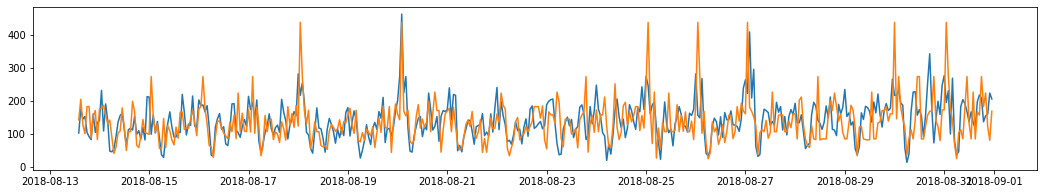

In [116]:
plt.figure(figsize = figsize)
plt.plot(target_test.index,
         target_test,
         target_test.index,
         predict_dtr)

### CatBoostRegressor

In [117]:
%%time
regressor_cbr.fit(features_train,
                  target_train)
predict_cbr = regressor_cbr.predict(features_test)
rmse_cbr_test = mean_squared_error(target_test, predict_cbr) ** 0.5
print('\nRMSE для CatBoostRegressor =', rmse_cbr_test, '\n')


RMSE для CatBoostRegressor = 40.41712327874132 

CPU times: user 13.5 s, sys: 1.63 s, total: 15.1 s
Wall time: 11.4 s


Посмотрим предсказания с реальными данными.

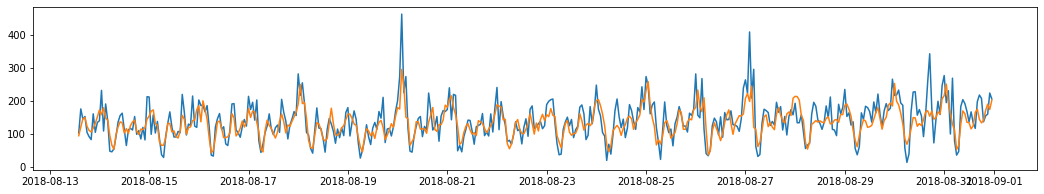

In [118]:
plt.figure(figsize = figsize)
plt.plot(target_test.index,
         target_test,
         target_test.index,
         predict_cbr)

### LGBMRegressor

In [119]:
%%time
regressor_lgbmr.fit(features_train,
                    target_train)
predict_lgbmr = regressor_lgbmr.predict(features_test)
rmse_lgbmr_test = mean_squared_error(target_test, predict_lgbmr) ** 0.5
print('\nRMSE для LGBMRegressor =', rmse_lgbmr_test, '\n')


RMSE для LGBMRegressor = 41.500149121968725 

CPU times: user 963 ms, sys: 15.6 ms, total: 978 ms
Wall time: 511 ms


Посмотрим предсказания с реальными данными.

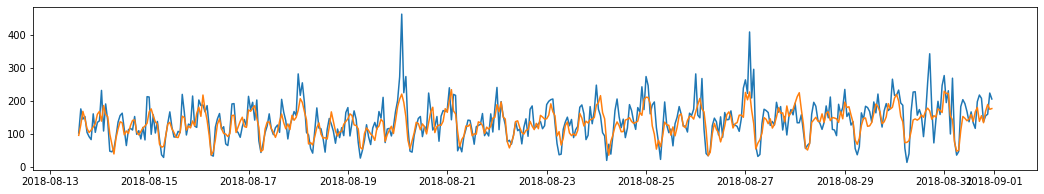

In [120]:
plt.figure(figsize = figsize)
plt.plot(target_test.index,
         target_test,
         target_test.index,
         predict_lgbmr)

In [121]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE на Train':[rmse_lr,
                         rmse_dtr,
                         rmse_cbr,
                         rmse_lgbmr],
        'RMSE на Test':[rmse_lr_test,
                        rmse_dtr_test,
                        rmse_cbr_test,
                        rmse_lgbmr_test]}
pivot = pd.DataFrame(data = data,
                     index=index)
pivot['Выполнение задачи'] = pivot['RMSE на Test'] < 48.0
pivot

,RMSE на Train,RMSE на Test,Выполнение задачи
LinearRegression,27.531,45.529,True
DecisionTreeRegressor,31.506,65.258,False
CatBoostRegressor,26.240,40.417,True
LGBMRegressor,26.911,41.500,True


### Вывод

В проекте были исследованы исторические данные о заказах такси в аэропортах. 

Были проанализированы 4 модели прогнозирования количество заказов такси на следующий час. Для трех из них удалось подобрать параметры, которые обеспечили требуемую точность предсказания в RMSE не больше 48.

Лучшей оказалась модель CatBoostRegressor с RMSE на тестовой выборке = 40.417.